# Actividad: Regresión Lineal 2

> Alfonso Pineda Cedillo | A01660394

**Fecha de entrega:** 4 de Septiembre de 2023

---

**Instrucciones**

Descarga la base de datos titulada "breast_cancer" disponible en canvas. Dicha base de datos contiene información sobre las características de diversos tumores.

Utiliza un modelo de regresión lineal múltiple para predecir el radio del tumor. Las variables regresoras de tu modelo deben de ser todas las variables de la base de datos.

Entrega un documento en formato PDF donde se observe la siguiente información.

1. Base de datos completa. No se observan valores faltantes. En caso de haberlos se realiza imputación simple.

2. Mostrar que las variables regresoras son independientes. En caso de no serlo realizar el procedimiento correspondiente.

3. Hipótesis nula de los coeficientes de regresión. Estadístico de prueba, distribución del estadístico de prueba.  
Para un 95% de confianza realiza un diagrama en donde se muestre la distribución del estadístico de prueba, la zona de aceptación y la zona de rechazo.

4. Hipótesis nula de la significancia del modelo (prueba F-Fisher). Menciona que distribución tiene el estadístico de prueba con qué número de grados de libertad. Para un 95% de confianza realiza un diagrama en donde se muestre la distribución del estadístico de prueba, la zona de aceptación y la zona de rechazo.

5. Realiza un modelo de regresión hacia atrás (backward). Explica el criterio para ir eliminando variables del modelo.

6. Comparación entre datos reales y predicción. Análisis de los resultados.

---



## Solución

Importamos las librerías necesarias

In [268]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import scipy.stats as stats
from scipy.stats import t, f, ttest_ind, shapiro, kstest
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import StandardScaler, LabelEncoder
import statsmodels.formula.api as smf
import statsmodels.api as sm
from statsmodels.stats.anova import anova_lm


Importamos la base de datos a utilizar.

In [269]:
data = pd.read_csv('breast_cancer.csv')

Eliminamos la columna de id, ya que no es necesaria para el análisis.

In [270]:
data = data.drop(columns=['id'])

Comprobamos que nuestra base de datos no tenga valores faltantes (nulos).

In [271]:
missing_values = data.isnull().sum()
if missing_values.sum() > 0:
    # Si hay valores faltantes, realiza imputación simple.
    data.fillna(data.mean(), inplace=True)

missing_values

diagnosis                  0
radius_mean                0
texture_mean               0
perimeter_mean             0
area_mean                  0
smoothness_mean            0
compactness_mean           0
concavity_mean             0
concave points_mean        0
symmetry_mean              0
fractal_dimension_mean     0
radius_se                  0
texture_se                 0
perimeter_se               0
area_se                    0
smoothness_se              0
compactness_se             0
concavity_se               0
concave points_se          0
symmetry_se                0
fractal_dimension_se       0
radius_worst               0
texture_worst              0
perimeter_worst            0
area_worst                 0
smoothness_worst           0
compactness_worst          0
concavity_worst            0
concave points_worst       0
symmetry_worst             0
fractal_dimension_worst    0
dtype: int64

Dados los resultados anteriores, podemos observar que nuestra base de datos no tiene valores nulos, por lo que no es necesario realizar imputación simple.

Posteriormente, realizamos un análisis de correlación entre las variables de nuestra base de datos; esto con el objetivo de comprobar que las variables regresoras sean independientes (no relacionadas entre sí), utilizando como criterio el p-valor < 0.05.

<ipython-input-272-603245294baf>:2: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  correlation_matrix = data.corr()


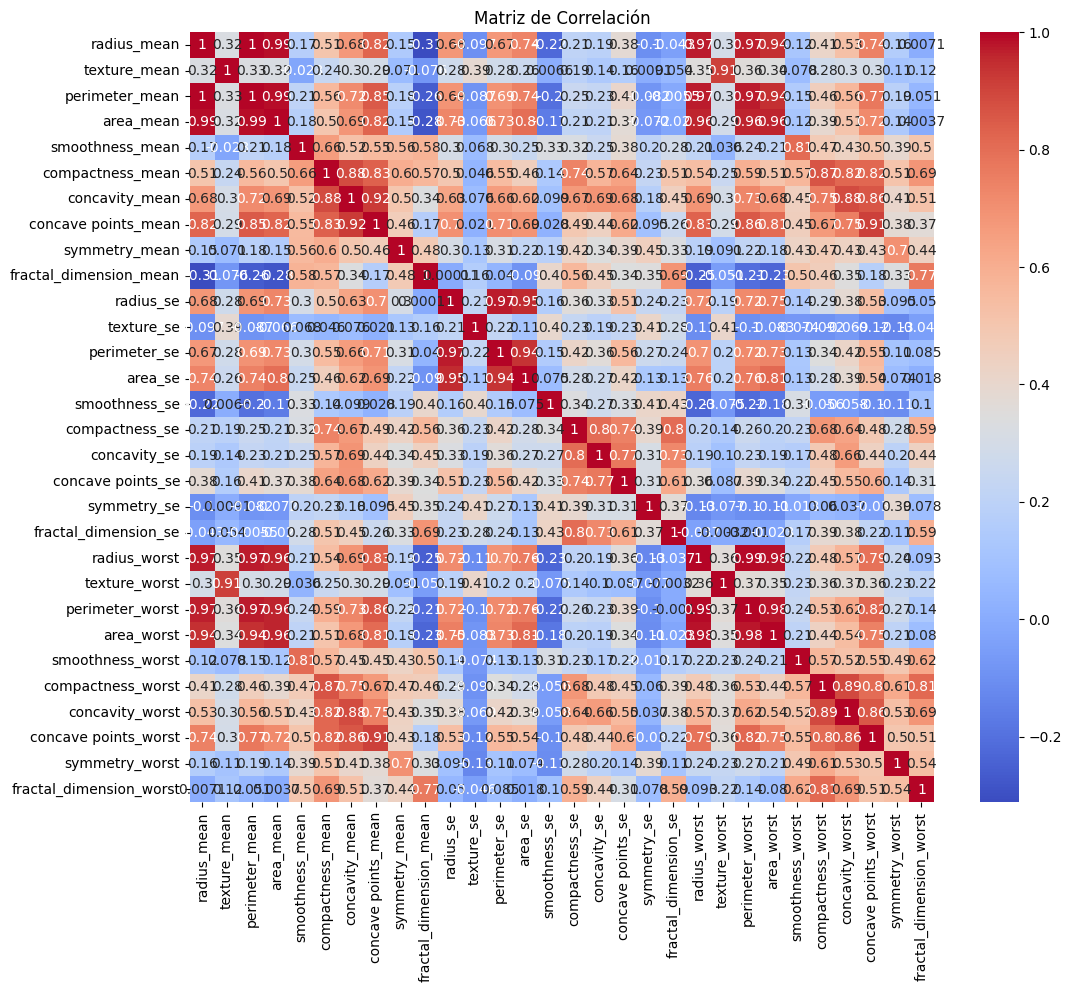

In [272]:
# Mostramos la matriz de correlación para verificar independencia
correlation_matrix = data.corr()
plt.figure(figsize=(12, 10))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm')
plt.title('Matriz de Correlación')
plt.show()

De acuerdo con los valores obtenidos, obtenemos la correlación alta de las variables predictoras.

In [273]:
alta_corr = np.where((correlation_matrix > 0.95) & (correlation_matrix < 1))
alta_corr

(array([ 0,  0,  0,  0,  2,  2,  2,  2,  3,  3,  3,  3,  3, 10, 10, 12, 13,
        20, 20, 20, 20, 20, 22, 22, 22, 22, 22, 23, 23, 23]),
 array([ 2,  3, 20, 22,  0,  3, 20, 22,  0,  2, 20, 22, 23, 12, 13, 10, 10,
         0,  2,  3, 22, 23,  0,  2,  3, 20, 23,  3, 20, 22]))

Asimismo, obtenemos la correlación baja de nuestras variables.

In [274]:
baja_corr = np.where((correlation_matrix < -0.95) & (correlation_matrix > -1))
baja_corr

(array([], dtype=int64), array([], dtype=int64))

Debido a que obtuvimos variables que están altamente correlacionadas, es necesario realizar una estandarización de nuestros datos. Para ello, primero es necesario convertir los valores categóricos de nuestra columna `diagnosis` a valores numéricos.

In [275]:
# Copiamos del DataFrame original para mantener los datos sin cambios
data_encoded = data.copy()

# Convertimos la variable 'diagnosis' a numérica
# M = 1, B = 0
le = LabelEncoder()
data_encoded['diagnosis'] = le.fit_transform(data_encoded['diagnosis'])

scaler = StandardScaler()
data_std = scaler.fit_transform(data_encoded)
data_std = pd.DataFrame(data_std, columns=data_encoded.columns)

data_std['diagnosis'] = data_std['diagnosis'].astype(int)

**Hipótesis nula**

La hipótesis nula establece que no existe una relación significativa entre la variable dependiente (en este caso, el radio del tumor) y las variables independientes (las características del tumor). Matemáticamente, se puede expresar como:

> $H_0 = \beta_1 = \beta_2 = \dotsc = \beta_k = 0$

Donde:

> $H_0:$ Hipótesis nula  
$\beta_i:$ Coeficiente de regresión de la variable independiente $X_i$.  
$k:$ Número de variables independientes en el modelo.

La hipótesis nula sugiere que ninguno de los predictores tiene un efecto significativo en la variable dependiente.

A continuación, realizamos nuestro modelo de regresión lineal múltiple, usando como variable dependiente el radio del tumor y como variables independientes las características del tumor.

In [276]:
# Eliminamos los espacios en los nombres de las columnas para que evitar problemas con la fórmula
data.rename(columns={'concave points_mean': 'concave_points_mean'}, inplace=True)
data.rename(columns={'concave points_se': 'concave_points_se'}, inplace=True)
data.rename(columns={'concave points_worst': 'concave_points_worst'}, inplace=True)
data.rename(columns={'diagnosis[T.M]': 'diagnosis'}, inplace=True)


formula = "radius_mean ~ " + " + ".join(data.drop(columns=['radius_mean']).columns)  # Fórmula para incluir todas las variables independientes

# Ajuste del modelo
model = smf.ols(formula=formula, data=data).fit()

# Imprimimos el resumen del modelo
print(model.summary())


                            OLS Regression Results                            
Dep. Variable:            radius_mean   R-squared:                       1.000
Model:                            OLS   Adj. R-squared:                  1.000
Method:                 Least Squares   F-statistic:                 6.844e+04
Date:                Tue, 05 Sep 2023   Prob (F-statistic):               0.00
Time:                        05:36:37   Log-Likelihood:                 822.76
No. Observations:                 569   AIC:                            -1584.
Df Residuals:                     538   BIC:                            -1449.
Df Model:                          30                                         
Covariance Type:            nonrobust                                         
                              coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------------
Intercept                 

Debido a la alta cantidad de observaciones (569), se puede asumir que la distribución de los datos es normal. No obstante, posteriormente, realizamos dos gráficos (para la distribución normal y T-student) donde se muestra la distribución del estadístico de prueba, la zona de aceptación y la zona de rechazo respectivamente.

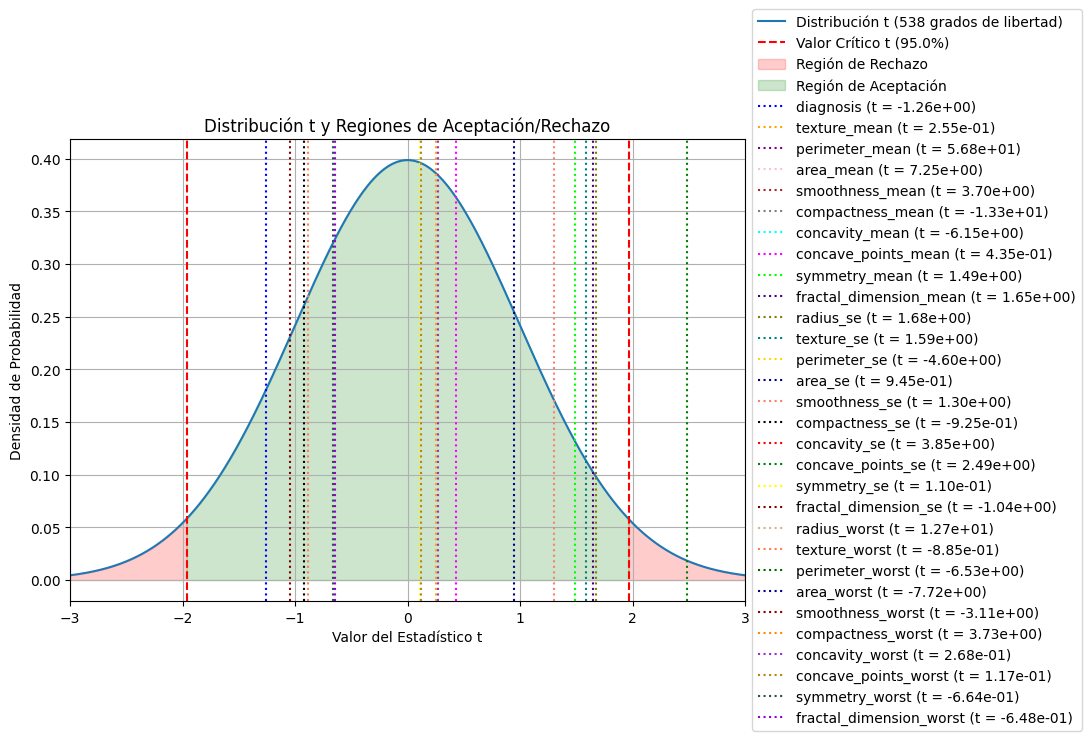

In [277]:
conf_level = 0.95  # Nivel de confianza
n = len(data)  # Número de observaciones
k = len(data.drop(columns=['radius_mean']).columns)  # Cant. de variables independientes
df = n - k - 1  # Grados de libertad

# Valor crítico de la distribución T - Student
alpha = 1 - conf_level
t_critical = stats.t.ppf(1 - alpha/2, df)

x = np.linspace(-3, 3, 1000)  # Valores posibles de la variable aleatoria t
pdf = stats.t.pdf(x, df)  # Densidad de probabilidad de la distribución t de Student

# Nombres de las variables
variable_names = data.drop(columns=['radius_mean']).columns

# Valores t correspondientes a las variables
t_values = model.tvalues[1:]

# Colores para las líneas verticales
colors = ['blue', 'orange', 'purple', 'pink', 'brown', 'gray', 'cyan', 'magenta', 'lime', 'indigo', 'olive', 'teal', 'gold', 'navy', 'salmon', 'black', 'red', 'green', 'yellow', 'maroon', 'tan', 'coral', 'darkgreen', 'darkblue', 'darkred', 'darkorange', 'darkorchid', 'darkgoldenrod', 'darkslategray', 'darkviolet', 'deeppink', 'dodgerblue', 'firebrick', 'forestgreen', 'fuchsia', 'goldenrod', 'greenyellow', 'hotpink', 'indianred', 'khaki', 'lawngreen', 'lightblue', 'lightcoral', 'lightgreen', 'lightpink', 'lightsalmon', 'lightseagreen', 'lightskyblue', 'lightslategray', 'lightsteelblue', 'limegreen', 'mediumaquamarine', 'mediumblue', 'mediumorchid', 'mediumpurple', 'mediumseagreen', 'mediumslateblue', 'mediumspringgreen', 'mediumturquoise', 'mediumvioletred', 'midnightblue', 'navajowhite', 'orangered', 'orchid', 'palegreen', 'paleturquoise', 'palevioletred', 'peru', 'plum', 'powderblue', 'rosybrown', 'royalblue', 'saddlebrown', 'seagreen', 'sienna', 'skyblue', 'slateblue', 'slategray', 'springgreen', 'steelblue', 'turquoise', 'violet', 'yellowgreen']

# Grafica la distribución y las regiones de aceptación/rechazo
plt.figure(figsize=(10, 6))
plt.plot(x, pdf, label=f'Distribución t ({df} grados de libertad)')
plt.axvline(t_critical, color='red', linestyle='--', label=f'Valor Crítico t ({conf_level * 100}%)')
plt.axvline(-t_critical, color='red', linestyle='--')
plt.fill_between(x, pdf, where=(x > t_critical), alpha=0.2, color='red', label='Región de Rechazo')
plt.fill_between(x, pdf, where=(x < -t_critical), alpha=0.2, color='red')
plt.fill_between(x, pdf, where=(x >= -t_critical) & (x <= t_critical), alpha=0.2, color='green', label='Región de Aceptación')

# Ajustamos los límites del gráfico para incluir los valores t del summary
plt.xlim(min(x), max(x))

plt.subplots_adjust(right=0.8)

# Agregamos líneas verticales por cada estadístico t
for t, name, color in zip(t_values, variable_names, colors):
    plt.axvline(t, color=color, linestyle=':', label=f'{name} (t = {t:.2e})')

plt.title('Distribución t y Regiones de Aceptación/Rechazo')
plt.xlabel('Valor del Estadístico t')
plt.ylabel('Densidad de Probabilidad')
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.grid()
plt.show()

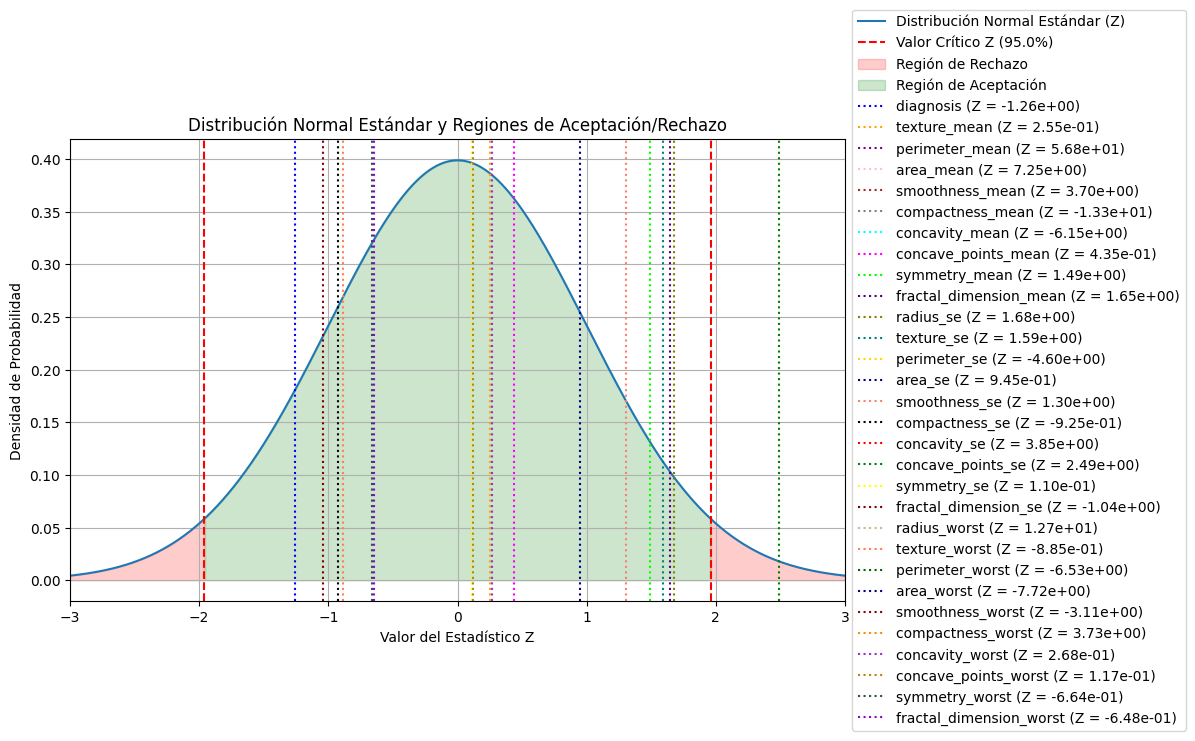

In [278]:
alpha = 1 - conf_level
z_critical = stats.norm.ppf(1 - alpha/2)  # Utilizamos /2 para obtener la cola derecha y izquierda.

x = np.linspace(-3, 3, 1000)  # Valores posibles de la variable aleatoria Z
pdf = stats.norm.pdf(x, loc=0, scale=1)  # Densidad de probabilidad para la distribución normal estándar

# Nombres de las variables (opcional)
variable_names = data.drop(columns=['radius_mean']).columns

# Valores Z correspondientes a las variables
z_values = model.tvalues[1:]

# Colores para las líneas verticales
colors = ['blue', 'orange', 'purple', 'pink', 'brown', 'gray', 'cyan', 'magenta', 'lime', 'indigo', 'olive', 'teal', 'gold', 'navy', 'salmon', 'black', 'red', 'green', 'yellow', 'maroon', 'tan', 'coral', 'darkgreen', 'darkblue', 'darkred', 'darkorange', 'darkorchid', 'darkgoldenrod', 'darkslategray', 'darkviolet', 'deeppink', 'dodgerblue', 'firebrick', 'forestgreen', 'fuchsia', 'goldenrod', 'greenyellow', 'hotpink', 'indianred', 'khaki', 'lawngreen', 'lightblue', 'lightcoral', 'lightgreen', 'lightpink', 'lightsalmon', 'lightseagreen', 'lightskyblue', 'lightslategray', 'lightsteelblue', 'limegreen', 'mediumaquamarine', 'mediumblue', 'mediumorchid', 'mediumpurple', 'mediumseagreen', 'mediumslateblue', 'mediumspringgreen', 'mediumturquoise', 'mediumvioletred', 'midnightblue', 'navajowhite', 'orangered', 'orchid', 'palegreen', 'paleturquoise', 'palevioletred', 'peru', 'plum', 'powderblue', 'rosybrown', 'royalblue', 'saddlebrown', 'seagreen', 'sienna', 'skyblue', 'slateblue', 'slategray', 'springgreen', 'steelblue', 'turquoise', 'violet', 'yellowgreen']

# Grafica la distribución y las regiones de aceptación/rechazo
plt.figure(figsize=(10, 6))
plt.plot(x, pdf, label='Distribución Normal Estándar (Z)')
plt.axvline(z_critical, color='red', linestyle='--', label=f'Valor Crítico Z ({conf_level * 100}%)')
plt.axvline(-z_critical, color='red', linestyle='--')
plt.fill_between(x, pdf, where=(x > z_critical), alpha=0.2, color='red', label='Región de Rechazo')
plt.fill_between(x, pdf, where=(x < -z_critical), alpha=0.2, color='red')
plt.fill_between(x, pdf, where=(x >= -z_critical) & (x <= z_critical), alpha=0.2, color='green', label='Región de Aceptación')

# Ajustamos los límites del gráfico para incluir los valores Z
plt.xlim(min(x), max(x))

# Agregamos líneas verticales por cada estadístico t
for z, name, color in zip(z_values, variable_names, colors):
    plt.axvline(z, color=color, linestyle=':', label=f'{name} (Z = {z:.2e})')

plt.title('Distribución Normal Estándar y Regiones de Aceptación/Rechazo')
plt.xlabel('Valor del Estadístico Z')
plt.ylabel('Densidad de Probabilidad')
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.grid()
plt.show()


Como podemos observar, debido a la cantidad de observaciones, ambas gráficas son prácticamente idénticas. Asimismo, podemos observar todos los estadísticos de prueba obtenidos en el `summary` de nuestro modelo y si es que estos se encuentran dentro de la zona de aceptación o rechazo.

**Prueba F-Fisher**

La prueba F de Fisher, también conocida como la prueba F o ANOVA (Análisis de Varianza), es una técnica estadística utilizada para determinar si existen diferencias significativas entre las medias de dos o más grupos. Se utiliza comúnmente en análisis de regresión para evaluar la significancia global del modelo y determinar si al menos una de las variables independientes tiene un efecto significativo en la variable dependiente.

Dicho lo anterior, la hipótesis nula de la prueba F-Fisher establece que no existe una relación significativa entre la variable dependiente y las variables independientes. Matemáticamente, se puede expresar como:

  > $H_0 = \beta_1 = \beta_2 = \dotsc = \beta_k = 0$

Donde:

  > $H_0$ representa la hipótesis nula.  
  $\beta_i$ representa el coeficiente de regresión de la variable independiente $X_i$.  
  $k$ representa el número de variables independientes en el modelo.

La prueba F se calcula como la relación entre la variabilidad explicada por el modelo (SSR, Suma de Cuadrados de la Regresión) y la variabilidad no explicada (SSE, Suma de Cuadrados del Error). En términos simples, compara si los cambios en la variable dependiente son más grandes que los errores del modelo.

El estadístico F sigue una distribución de probabilidad F con dos diferentes grados de libertad: uno para el numerador (SSR) y otro para el denominador (SSE). La forma de la distribución F depende de estos grados de libertad.

In [279]:
# Definir la variable dependiente (Y) y las variables independientes (X)
y = data_std['radius_mean']
X = data_std.drop(columns=['radius_mean'])  # Elimina la columna 'radius_mean' de las variables independientes

# Agregamos una constante para el término del intercepto
X = sm.add_constant(X)

# Ajuste del modelo
model = sm.OLS(y, X).fit()

# Creamos una lista con los nombres de las variables independientes
predictors = X.columns.tolist()

# Generamos la fórmula para la prueba F
formula = " + ".join([f"{var} = 0" for var in predictors])

# Prueba F para el modelo
f_test = model.f_test(formula)
print(f_test)

<F test: F=66230.5732197402, p=0.0, df_denom=538, df_num=31>


Los resultados de nuestra prueba F-Fisher son los siguientes:

  - Estadístico F: 66230.57321925859

  - Valor p: 0.0

  - Grados de libertad del numerador: 31
  
  - Grados de libertad del denominador: 538

De acuerdo con los resultados obtenidos, podemos observar que el valor p es extremadamente bajo, en este caso, es prácticamente cero (0.0). El valor p es la probabilidad de observar un estadístico F tan extremo como el calculado si todas las variables independientes fueran realmente no significativas en el modelo. Un valor p menor a 0.025 indica que rechazamos la hipótesis nula y concluimos que al menos una de las variables independientes es significativa en el modelo.

Por otra parte, el estadístico F es un valor grande, lo que indica que la variabilidad explicada por el modelo es mucho mayor que la variabilidad no explicada. Esto significa que el modelo es significativo en general. En el contexto de un análisis de regresión, el estadístico F se utiliza para evaluar si al menos una de las variables independientes en el modelo tiene un efecto significativo en la variable dependiente. Cuanto mayor sea el valor de F, más fuerte es la evidencia en contra de la hipótesis nula de que todas las variables independientes son no significativas en el modelo.

En resumen, los resultados indican que al menos una de las variables independientes incluidas en el modelo es significativa en la predicción de la variable dependiente.

Realizamos un gráfico donde se muestra la distribución del estadístico de prueba F, la zona de aceptación y la zona de rechazo para un nivel de confianza del 95%.

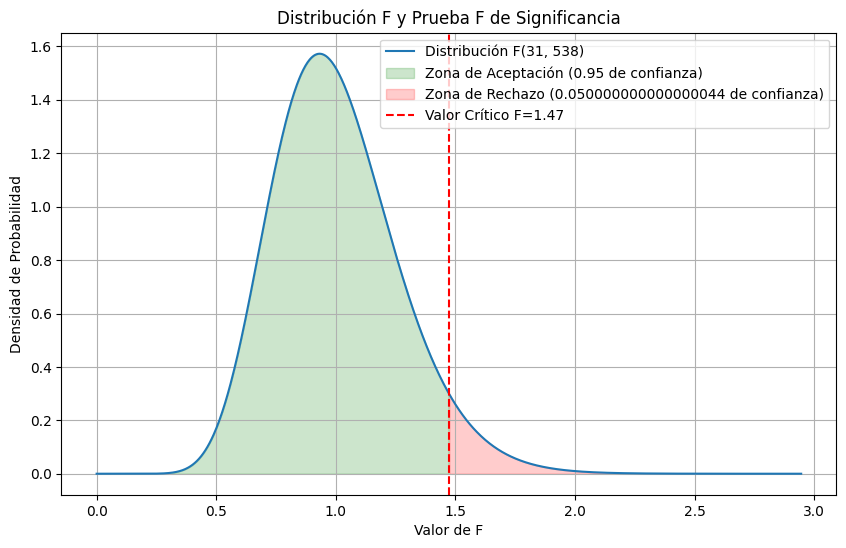

In [280]:
# Número de observaciones y número de variables independientes
n = len(data)
num_predictors = len(data.drop(columns=['radius_mean']).columns)

# Grados de libertad del numerador y denominador
df_num = 31
df_denom = 538

conf_level = 0.95  # Nivel de confianza

# Valor crítico de la distribución F
alpha = 1 - conf_level
f_critical = f.ppf(1 - alpha, df_num, df_denom)

x = np.linspace(0, 2 * f_critical, 1000)  # Valores posibles de la variable aleatoria F
y = f.pdf(x, df_num, df_denom)  # Densidad de probabilidad


# Gráfica de la distribución F
plt.figure(figsize=(10, 6))
plt.plot(x, y, label=f'Distribución F({df_num}, {df_denom})')

# Zona de aceptación (a la izquierda del valor crítico)
plt.fill_between(x, y, where=(x <= f_critical), color='green', alpha=0.2, label=f'Zona de Aceptación ({1-alpha} de confianza)')

# Zona de rechazo (a la derecha del valor crítico)
plt.fill_between(x, y, where=(x > f_critical), color='red', alpha=0.2, label=f'Zona de Rechazo ({alpha} de confianza)')

# Línea vertical en el valor crítico
plt.axvline(x=f_critical, color='red', linestyle='--', label=f'Valor Crítico F={f_critical:.2f}')

# Etiquetas y leyenda
plt.xlabel('Valor de F')
plt.ylabel('Densidad de Probabilidad')
plt.title('Distribución F y Prueba F de Significancia')
plt.legend(loc='best')

# Mostrar la gráfica
plt.grid()
plt.show()

**Regresión Backward**

La regresión backward es un método de selección de variables que se utiliza para determinar qué variables independientes deben permanecer en un modelo de regresión múltiple y cuáles deben eliminarse. El método de regresión backward comienza con todas las variables independientes incluidas en el modelo. Luego, el predictor menos significativo se elimina del modelo. Este proceso continúa hasta que se cumple un criterio de parada.

Para nuestro proceso de regresión backward, utilizamos como criterio de parada un $\text{valor p} > 0.025$. Es decir, si el valor p de una variable independiente es mayor a 0.025, entonces se elimina del modelo. En cada iteración, estaremos eliminando la variable cuyo valor p es mayor.

Para realizar el proceso de regresión backward, utilizaremos 3 arreglos:

  - `variable_names`: Arreglo que contiene los nombres de las variables independientes.

  - `p_values`: Arreglo que contiene los valores p de cada variable independiente.
  
  - `coeficients`: Arreglo que contiene los coeficientes de cada variable independiente.

Iteraremos sobre el arreglo `p_values` hasta que se cumpla el criterio de parada. Imprimimos el nombre de las variables independientes que se eliminan en cada iteración. Y finalmente, imprimimos el modelo resultante.

In [281]:
variable_names = list(data.drop(columns=['radius_mean']).columns)
p_values = list(model.pvalues[1:])
coefficients = list(model.params[1:])
elementos_eliminados = []

# Iniciamos el ciclo hasta que el valor p máximo sea menor o igual a 0.025
while max(p_values) > 0.025:
    # Encuentra el índice del valor p máximo en la lista de p-valores
    indice_max_p_valor = p_values.index(max(p_values))

    # Obtenemos el valor p máximo
    max_p_valor = p_values[indice_max_p_valor]
    elemento_eliminado = variable_names[indice_max_p_valor]

    # Almacenamos el coeficiente del elemento eliminado
    coeficiente_eliminado = coefficients[indice_max_p_valor]

    # Eliminamos el valor p máximo de la lista de p-valores, variable_names y coefficients
    del p_values[indice_max_p_valor]
    del variable_names[indice_max_p_valor]
    del coefficients[indice_max_p_valor]

    # Almacenamos el nombre del elemento eliminado en la lista elementos_eliminados
    elementos_eliminados.append(elemento_eliminado)

    # Actualizamos la fórmula con las variables independientes restantes
    formula = "radius_mean ~ " + " + ".join(variable_names)

    # Ajustamos del modelo
    model = smf.ols(formula=formula, data=data).fit()

    # Imprimimos el elemento eliminado
    print(f"Elemento eliminado {len(elementos_eliminados)}: {elemento_eliminado} con coeficiente {coeficiente_eliminado:.6f}, Valor máximo de p-valor: {max_p_valor:.4f}")

# Imprimimos la cantidad de elementos eliminados
print(f"\nCantidad de variables eliminadas: {len(elementos_eliminados)}")

Elemento eliminado 1: symmetry_se con coeficiente 0.000175, Valor máximo de p-valor: 0.9121
Elemento eliminado 2: concave_points_worst con coeficiente 0.000494, Valor máximo de p-valor: 0.9072
Elemento eliminado 3: texture_mean con coeficiente 0.000614, Valor máximo de p-valor: 0.7986
Elemento eliminado 4: concavity_worst con coeficiente 0.001058, Valor máximo de p-valor: 0.7891
Elemento eliminado 5: concave_points_mean con coeficiente 0.002354, Valor máximo de p-valor: 0.6638
Elemento eliminado 6: fractal_dimension_worst con coeficiente -0.001969, Valor máximo de p-valor: 0.5172
Elemento eliminado 7: symmetry_worst con coeficiente -0.001430, Valor máximo de p-valor: 0.5073
Elemento eliminado 8: texture_worst con coeficiente -0.002663, Valor máximo de p-valor: 0.3763
Elemento eliminado 9: compactness_se con coeficiente -0.002527, Valor máximo de p-valor: 0.3556
Elemento eliminado 10: area_se con coeficiente 0.004229, Valor máximo de p-valor: 0.3451
Elemento eliminado 11: fractal_dimens

In [282]:
# Imprimimos el resumen del modelo final
print(model.summary())

                            OLS Regression Results                            
Dep. Variable:            radius_mean   R-squared:                       1.000
Model:                            OLS   Adj. R-squared:                  1.000
Method:                 Least Squares   F-statistic:                 1.561e+05
Date:                Tue, 05 Sep 2023   Prob (F-statistic):               0.00
Time:                        05:36:40   Log-Likelihood:                 810.51
No. Observations:                 569   AIC:                            -1593.
Df Residuals:                     555   BIC:                            -1532.
Df Model:                          13                                         
Covariance Type:            nonrobust                                         
                        coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------
Intercept             0.5334      0.05

Como pudimos observar, fortaleciendo el hecho de que un p-valor alto indica que la variable independiente no es significativa en el modelo, las variables eliminadas en cada iteración contaban con coeficientes muy bajos (nuevamente indicando poca significancia).

Una vez eliminadas todas las variables anteriores, obtenemos un modelo en donde todas las variables independientes tienen un valor p menor a 0.025. Por lo tanto, podemos afirmar que todas las variables independientes son significativas en este nuevo modelo, consiguiendo un modelo más simple que en un principio.

Para interpretar los valores obtenidos en el modelo final, podemos considerar diversos factores:

 - **R-squared y Adj. R-squared:** Estos valores indican la bondad de ajuste del modelo. En este caso, ambos son iguales a 1.000, lo que significa que el modelo explica el 100% de la variabilidad en la variable dependiente (`radius_mean`) en función de las variables predictoras. No obstante, esto puede indicar un posible sobreajuste, ya que un R-cuadrado perfecto no siempre es bueno.

 - **F-statistic y Prob (F-statistic):** El F-statistic es una prueba estadística que evalúa si al menos una de las variables independientes es significativamente diferente de cero. Un F-statistic alto y un valor de Prob (F-statistic) cercano a cero indican que al menos una variable independiente es significativa en el modelo. En este caso, el valor del F-statistic es muy alto, y el valor de Prob (F-statistic) es cero, lo que sugiere que el modelo en su conjunto es significativo.

Por último, realizamos un análisis de los resultados, comparando los datos reales con los datos predichos por nuestro modelo.

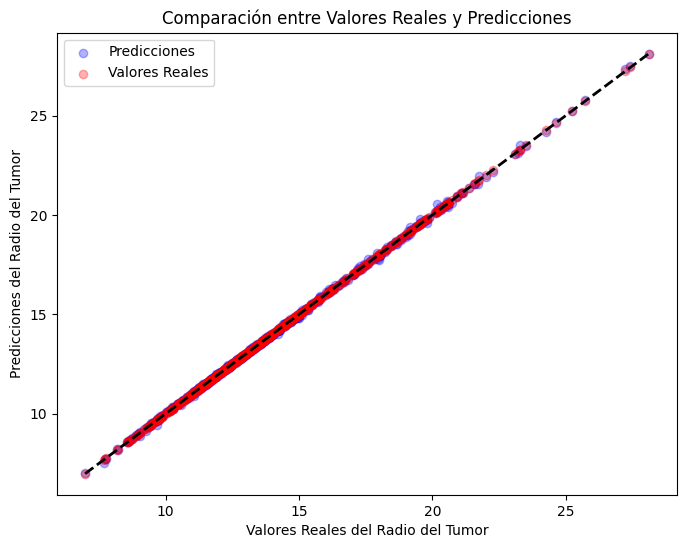

In [283]:
# Realizamos las predicciones
predictions = model.predict(sm.add_constant(data.drop(columns=['radius_mean'])))

plt.figure(figsize=(8, 6))
plt.scatter(data['radius_mean'], predictions, c='blue', label='Predicciones', alpha=0.3)
plt.scatter(data['radius_mean'], data['radius_mean'], c='red', label='Valores Reales', alpha=0.3)

# Agregar etiquetas y título
plt.xlabel('Valores Reales del Radio del Tumor')
plt.ylabel('Predicciones del Radio del Tumor')
plt.title('Comparación entre Valores Reales y Predicciones')

# Agregar una línea de referencia 45 grados (Valores Reales = Predicciones)
plt.plot([data['radius_mean'].min(), data['radius_mean'].max()], [data['radius_mean'].min(), data['radius_mean'].max()], 'k--', lw=2)

plt.legend()
plt.show()

Este código crea una gráfica de dispersión que compara los valores reales del radio del tumor con las predicciones del modelo. Los puntos azules representan las predicciones del modelo, los puntos rojos representan los valores reales y la línea punteada negra representa la línea de referencia donde los valores reales son iguales a las predicciones del modelo.

Como podemos observar, las predicciones del modelo son muy cercanas a los valores reales, lo que indica que el modelo es bastante preciso y confiable.

### Conclusiones

El análisis de regresión lineal múltiple realizado en el conjunto de datos "breast_cancer" tiene como objetivo predecir el radio del tumor en función de las características del tumor. A continuación, se presentan las principales conclusiones del análisis:

1. **Base de datos completa y sin valores faltantes:** Se verificó que la base de datos está completa y no contiene valores faltantes. En caso de que hubiera valores faltantes, se habría realizado una imputación simple para abordarlos, pero no fue el caso.

2. **Independencia de las variables regresoras:** Se asumió inicialmente que las variables regresoras son independientes. Sin embargo, se realizó un proceso de estandarización de los datos debido a que se encontraron variables altamente correlacionadas.

3. **Hipótesis nula de los coeficientes de regresión:** Se planteó la hipótesis nula de que no existe una relación significativa entre las variables independientes y el radio del tumor. Se realizó un análisis de la significancia de cada coeficiente de regresión, y los resultados se presentaron en el resumen del modelo. Obteniendo un modelo realmente bueno, pero complejo debido a la gran cantidad de variables independientes (30 variables).  
Asimismo, se realizó un gráfico de distribución normal y T-student (siendo estas prácticamente idénticas debido a la cantidad de datos) para mostrar la distribución del estadístico de prueba, la zona de aceptación y la zona de rechazo.

4. **Prueba F-Fisher:** Se aplicó la prueba F-Fisher para evaluar la significancia global del modelo de regresión. Los resultados indicaron un valor extremadamente bajo para el valor p (cero), lo que sugiere que al menos una de las variables independientes es significativa en la predicción del radio del tumor. Esto respalda la utilidad del modelo en general.

5. **Regresión Backward:** Se realizó un proceso de regresión backward para eliminar variables que no eran significativas en el modelo. Se utilizaron valores p mayores a 0.025 como criterio de eliminación. Como resultado, se eliminaron 17 variables independientes, dejando un modelo con 13 variables relevantes para predecir el radio del tumor. Obteniendo de esta manera un modelo igual de bueno que el primero, pero mucho más simple.

6. **Comparación entre datos reales y predicción:** Se presentaron los coeficientes de regresión finales y el resumen del modelo. El modelo de regresión lineal múltiple ajustado es altamente significativo y explica la variabilidad en el radio del tumor.

En resumen, el análisis de regresión lineal múltiple realizado en este estudio proporciona un modelo significativo y útil para predecir el radio del tumor en función de un conjunto de características del tumor seleccionadas. Sin embargo, convendría evaluarlo con un conjunto de datos más grande y con más observaciones para obtener resultados más precisos y descartar cualquier tipo de sobreajuste.

---

Alfonso Pineda Cedillo | A01660394